In [37]:
TRAIN_JSONL_PATH = "data_raw/train.jsonl"
EVAL_JSONL_PATH = "data_raw/dev.jsonl"
TEST_JSONL_PATH = "data_raw/test.jsonl"

In [38]:
from helper.utils import read_jsonl

train = read_jsonl(TRAIN_JSONL_PATH)
eval = read_jsonl(EVAL_JSONL_PATH)
test = read_jsonl(TEST_JSONL_PATH)

### Keras

In [5]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<Axes: >

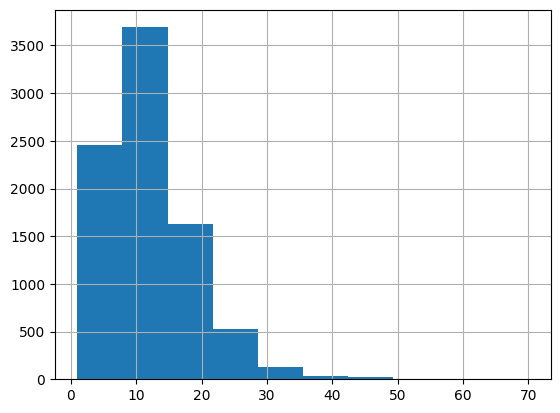

In [13]:
df["text"].apply(lambda t: len(t.split(" "))).hist()

### FastText Word Embeddings

In [39]:
train['text'].to_csv('data_cache/train_data.txt', index=False, header=False)
train_ids = train['id'].to_numpy()
train_indices = train.index

eval['text'].to_csv('data_cache/eval_data.txt', index=False, header=False)
eval_ids = eval['id'].to_numpy()
eval_indices = eval.index

test['text'].to_csv('data_cache/test_data.txt', index=False, header=False)
test_ids = test['id'].to_numpy()
test_indices = test.index


In [34]:
%pip install fasttext

Note: you may need to restart the kernel to use updated packages.


### Getting the text embeddings

In [ ]:
NUMBER_OF_EMBEDDING = 128

In [40]:
import fasttext

file_path = 'data_cache/train_data.txt'

def train_predict_embedding(file_path, df, indices, embedding_dimension=100):
    # Train FastText model
    model = fasttext.train_unsupervised(file_path, dim=embedding_dimension)  # Set desired embedding dimension (n=100 in this example)
    embedding_df = predict_embedding(df, indices, model)
    return embedding_df, model


def predict_embedding(df, indices, model):
    # Create an empty list to store the word embeddings
    embedding_list = []

    # Iterate over each row in the original DataFrame
    for index, row in df.iterrows():
        text = row['text']
        
        # Obtain the word embedding for the current text using FastText
        embedding = model.get_sentence_vector(text)
        
        # Append the embedding vector to the list
        embedding_list.append(embedding)

    # Create a DataFrame from the embedding list
    embedding_df = pd.DataFrame(embedding_list, index=indices)
    return embedding_df

train_embedding_df, train_model = train_predict_embedding(file_path, train, train_indices, embedding_dimension=NUMBER_OF_EMBEDDING)
eval_embedding_df = predict_embedding(eval, eval_indices, train_model)
test_embedding_df = predict_embedding(test, test_indices, train_model)

Read 0M words
Number of words:  2265
Number of labels: 0
Progress: 100.0% words/sec/thread:  118973 lr:  0.000000 avg.loss:  2.754663 ETA:   0h 0m 0s


In [41]:
print("Train shape:", train_embedding_df.shape)
print("Eval shape:", eval_embedding_df.shape)
print("Test shape:", test_embedding_df.shape)

Train shape: (8500, 100)
Eval shape: (500, 100)
Test shape: (1000, 100)


In [42]:
train_embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.047270,0.081864,0.032437,-0.151744,0.049869,0.274994,-0.136769,0.058721,0.111738,0.030274,...,-0.048635,-0.003773,0.056420,0.018093,-0.000858,-0.126719,0.038306,0.173042,-0.080767,-0.104416
1,-0.044260,0.081599,0.024389,-0.146163,0.046460,0.255240,-0.134738,0.052368,0.105872,0.032185,...,-0.047174,0.003364,0.052712,0.018431,0.001211,-0.129407,0.036726,0.171141,-0.089248,-0.101055
2,-0.052200,0.073329,0.021844,-0.134351,0.040769,0.272686,-0.140101,0.064538,0.109800,0.024105,...,-0.045449,-0.020424,0.046338,0.003759,-0.008393,-0.137328,0.047681,0.180136,-0.073047,-0.107347
3,-0.045982,0.080845,0.045772,-0.142562,0.057844,0.263742,-0.130115,0.042216,0.113192,0.018307,...,-0.054534,0.001266,0.029108,0.038134,0.001083,-0.127383,0.049963,0.161953,-0.076331,-0.104860
4,-0.045905,0.074049,0.047349,-0.165169,0.053242,0.253701,-0.123233,0.041848,0.109165,0.023452,...,-0.042046,0.025660,0.017383,0.065593,0.040692,-0.127206,0.060397,0.129530,-0.067772,-0.088842


In [47]:
train_embedding_df.columns = [f"embedding_{i}" for i in range(100)]
eval_embedding_df.columns = [f"embedding_{i}" for i in range(100)]
test_embedding_df.columns = [f"embedding_{i}" for i in range(100)]

In [48]:
train_df = pd.concat([train, train_embedding_df], axis=1)
eval_df = pd.concat([eval, eval_embedding_df], axis=1)
test_df = pd.concat([test, test_embedding_df], axis=1)

In [49]:
train_df

,id,img,label,text,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,42953,img/42953.png,0,its their character not their color that matters,-0.047270,0.081864,0.032437,-0.151744,0.049869,0.274994,...,-0.048635,-0.003773,0.056420,0.018093,-0.000858,-0.126719,0.038306,0.173042,-0.080767,-0.104416
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,-0.044260,0.081599,0.024389,-0.146163,0.046460,0.255240,...,-0.047174,0.003364,0.052712,0.018431,0.001211,-0.129407,0.036726,0.171141,-0.089248,-0.101055
2,13894,img/13894.png,0,putting bows on your pet,-0.052200,0.073329,0.021844,-0.134351,0.040769,0.272686,...,-0.045449,-0.020424,0.046338,0.003759,-0.008393,-0.137328,0.047681,0.180136,-0.073047,-0.107347
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,-0.045982,0.080845,0.045772,-0.142562,0.057844,0.263742,...,-0.054534,0.001266,0.029108,0.038134,0.001083,-0.127383,0.049963,0.161953,-0.076331,-0.104860
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",-0.045905,0.074049,0.047349,-0.165169,0.053242,0.253701,...,-0.042046,0.025660,0.017383,0.065593,0.040692,-0.127206,0.060397,0.129530,-0.067772,-0.088842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me,-0.045192,0.074408,0.024739,-0.151259,0.045008,0.251603,...,-0.039814,0.011666,0.047209,0.029729,0.017960,-0.131266,0.047878,0.154705,-0.077875,-0.091505
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...,-0.052499,0.081615,0.026845,-0.135304,0.059427,0.257379,...,-0.050631,0.002973,0.037462,0.017821,-0.016634,-0.133816,0.041322,0.178717,-0.085002,-0.105303
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...,-0.050020,0.079950,0.026544,-0.149998,0.059165,0.254236,...,-0.046180,0.018171,0.036450,0.035016,0.002749,-0.130826,0.042566,0.162116,-0.082863,-0.095731
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...,-0.049243,0.076357,0.031078,-0.139587,0.047423,0.260321,...,-0.048230,-0.004488,0.045110,0.013440,-0.008226,-0.128305,0.041859,0.177018,-0.076560,-0.105905


In [50]:
eval_df

,id,img,label,text,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,8291,img/08291.png,1,white people is this a shooting range,-0.044118,0.073505,0.006377,-0.152057,0.055546,0.260405,...,-0.042541,0.010263,0.069265,0.005871,0.008827,-0.130177,0.029630,0.174535,-0.092182,-0.089425
1,46971,img/46971.png,1,bravery at its finest,-0.053308,0.080884,0.010429,-0.154307,0.043037,0.247641,...,-0.028996,0.034932,0.043154,0.029867,0.033205,-0.136498,0.054121,0.154922,-0.096709,-0.092956
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...,-0.050203,0.085872,0.019786,-0.138870,0.047704,0.267694,...,-0.048717,-0.007699,0.045629,0.013364,-0.019423,-0.126465,0.036557,0.176207,-0.083705,-0.105331
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...,-0.053663,0.083700,0.013840,-0.142734,0.047517,0.256752,...,-0.042667,0.010940,0.060151,0.009012,-0.003595,-0.127037,0.035400,0.173478,-0.090127,-0.102892
4,80243,img/80243.png,1,mississippi wind chime,-0.065337,0.077619,0.018554,-0.156439,0.078945,0.280429,...,-0.034128,0.021105,0.021559,0.048019,0.017473,-0.153827,0.076032,0.167606,-0.085553,-0.099981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,83675,img/83675.png,0,i'm gonna be like phelps one day,-0.049978,0.077935,0.029250,-0.142618,0.040006,0.261822,...,-0.043768,-0.004364,0.045655,0.015537,0.000340,-0.133254,0.047590,0.175951,-0.081033,-0.110680
496,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...,-0.045245,0.083758,0.022864,-0.131888,0.038656,0.260670,...,-0.051197,-0.014590,0.059152,-0.001746,-0.016563,-0.127816,0.032511,0.185832,-0.083180,-0.113171
497,48670,img/48670.png,0,look at this sandwich maker club i found on wi...,-0.058223,0.080685,-0.000066,-0.147074,0.040670,0.239179,...,-0.025872,0.030870,0.041575,0.021344,0.023902,-0.135266,0.048905,0.163238,-0.100240,-0.090904
498,9863,img/09863.png,0,diverse group of women,-0.056714,0.083491,0.018609,-0.141465,0.053507,0.265233,...,-0.043691,0.006739,0.039887,0.018059,-0.008979,-0.131635,0.046678,0.172999,-0.087206,-0.107798


In [51]:
test_df

,id,img,text,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,16395,img/16395.png,handjobs sold seperately,-0.055682,0.082428,0.027263,-0.139218,0.058589,0.267270,-0.126181,...,-0.052421,0.003970,0.033836,0.026028,-0.015005,-0.136133,0.045633,0.184169,-0.085579,-0.107059
1,37405,img/37405.png,introducing fidget spinner for women,-0.043320,0.073106,0.035498,-0.133698,0.056324,0.275826,-0.141679,...,-0.058128,-0.018209,0.054429,0.009648,-0.020392,-0.127842,0.036101,0.181703,-0.074636,-0.109306
2,94180,img/94180.png,happy pride month let's go beat up lesbians,-0.047228,0.078096,0.024279,-0.135974,0.047182,0.261633,-0.132713,...,-0.050841,-0.001076,0.054290,0.011062,-0.012524,-0.132647,0.037528,0.187195,-0.086391,-0.106988
3,54321,img/54321.png,laughs in [majority of u.s crime rate],-0.060281,0.086156,0.022587,-0.142785,0.073605,0.265158,-0.113918,...,-0.050364,0.016910,0.018497,0.039311,-0.013486,-0.133153,0.047211,0.172917,-0.080223,-0.096688
4,97015,img/97015.png,finds out those 72 virgins.. are goats,-0.046343,0.077405,0.031374,-0.147016,0.049259,0.270492,-0.134998,...,-0.049348,-0.002919,0.051528,0.018888,-0.003510,-0.130349,0.040928,0.174138,-0.081116,-0.108714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3869,img/03869.png,a mother's love for the child is a divine thing,-0.043596,0.071649,0.021350,-0.144111,0.047820,0.262714,-0.145440,...,-0.050531,-0.005000,0.072216,-0.000174,-0.002168,-0.125655,0.027597,0.177722,-0.079459,-0.097614
996,23817,img/23817.png,sea monkeys,-0.063568,0.090432,0.027261,-0.141797,0.074833,0.261448,-0.112879,...,-0.051569,0.021409,0.031796,0.037884,-0.013264,-0.130613,0.050331,0.176603,-0.087333,-0.099329
997,56280,img/56280.png,little miss muffet sat on her tuffet,-0.057040,0.077044,0.019531,-0.140951,0.043943,0.257759,-0.124536,...,-0.041319,0.008929,0.039901,0.014965,-0.005057,-0.135704,0.042235,0.178850,-0.089424,-0.107502
998,29384,img/29384.png,they're in a row,-0.048560,0.079420,0.025237,-0.128166,0.062118,0.258481,-0.126353,...,-0.055795,-0.004602,0.040358,0.012497,-0.029748,-0.125328,0.035054,0.185169,-0.076505,-0.103528


In [52]:
train_df.to_csv('data_preprocessed/train_embedding.csv', index=False)
eval_df.to_csv('data_preprocessed/eval_embedding.csv', index=False)
test_df.to_csv('data_preprocessed/test_embedding.csv', index=False)